# Capstone Project: London Venues and Rental Prices

**Aim: to explore how accurately London rental prices can be predicted using geospatial data.**

1. Build a Dataframe of London postcode district coordinates, population and rental prices
2. Plot postcode districts on a Folium map
3. Call Foursquare API for venue information and create new dataframe
4. Explore data visually before processing with ML algorithms
5. Train a mutliple linear regression algorithm with a subset of the data
6. Assess the regression model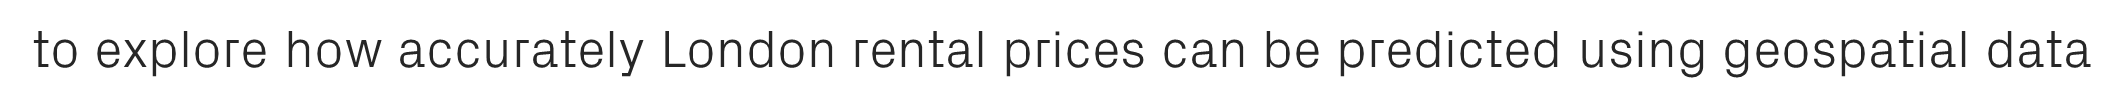

## 1. Build a Dataframe of London postcode district coordinates, population and rental prices

**a. Download the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import json
import requests
from pandas.io.json import json_normalize 
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium
from geopy.geocoders import Nominatim
import math
import matplotlib.pyplot as plt
import matplotlib.pylab
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from scipy import stats

**b. Download csv of postcode district coordinates and population** \
*Data source: https://ons.maps.arcgis.com/home/item.html?id=7c52dfecf65d4531bb5ed08f4fc2fa6a via https://www.doogal.co.uk/PostcodeDistricts.php*
\
\
Note: the census data for population at district level is only taken every 10 years, the last time being 2011. So the population data is fairly out-of-date, but will suffice for this project.

In [2]:
df1 = pd.read_csv(r"C:\Users\maxwe\OneDrive\Documents\IBM Exercises\Capstone Project\Postcode districts.csv")
df1.head(3)

,Postcode,Latitude,Longitude,Easting,Northing,Grid Reference,Town/Area,Region,Postcodes,Active postcodes,Population,Households,Nearby districts
0,AB1,57.1269,-2.13644,391839.0,804005.0,NJ918040,Aberdeen,Aberdeen,2655.0,0.0,NaN,NaN,"AB10, AB9, AB15, AB25, AB2, AB12, AB16, AB11, ..."
1,AB2,57.1713,-2.14152,391541.0,808948.0,NJ915089,Aberdeen,Aberdeen,3070.0,0.0,NaN,NaN,"AB16, AB22, AB24, AB25, AB1, AB9, AB15, AB10, ..."
2,AB3,57.0876,-2.59624,363963.0,799780.0,NO639997,Aberdeen,Aberdeen,2168.0,0.0,NaN,NaN,"AB31, AB34, AB52, AB33, AB14, AB32, AB30, AB13..."


**c. Download csv of postcode rental prices** \
*Data source: https://www.gov.uk/government/publications/private-rental-market-in-london-july-2018-to-june-2019*

In [3]:
df2 = pd.read_csv(r"C:\Users\maxwe\OneDrive\Documents\IBM Exercises\Capstone Project\VOA London Rent 2019.csv")
df2.head(10)

,Postcode District,Bedroom Category,Count of rents,Mean,Lower quartile,Median,Upper quartile
0,BR1,Room,20,535,492,542,600
1,BR1,Studio,10,706,600,753,775
2,BR1,One Bedroom,120,1033,950,1050,1100
3,BR1,Two Bedrooms,230,1238,1100,1250,1350
4,BR1,Three Bedrooms,90,1484,1350,1475,1600
5,BR1,Four or More Bedrooms,40,2487,1975,2375,2900
6,BR2,Room,10,657,600,675,700
7,BR2,Studio,-,..,..,..,..
8,BR2,One Bedroom,80,982,900,975,1050
9,BR2,Two Bedrooms,200,1259,1150,1250,1350


**d. Clean up `df1` and ensure only London based districts are included**

In [4]:
# Drop rows which are not in the London boroughs listed in the rental price dataset
df1v2 = df1[(df1['Region'] == 'Barking and Dagenham') | 
             (df1['Region'] == 'Barnet') |
             (df1['Region'] == 'Bexley') |
             (df1['Region'] == 'Brent') |
             (df1['Region'] == 'Bromley') |
             (df1['Region'] == 'Camden') |
             (df1['Region'] == 'City of London') |
             (df1['Region'] == 'Croydon') |
             (df1['Region'] == 'Ealing') |
             (df1['Region'] == 'Enfield') |
             (df1['Region'] == 'Greenwich') |
             (df1['Region'] == 'Hackney') |
             (df1['Region'] == 'Hammersmith and Fulham') |
             (df1['Region'] == 'Haringey') |
             (df1['Region'] == 'Harrow') |
             (df1['Region'] == 'Havering') |
             (df1['Region'] == 'Hillingdon') |
             (df1['Region'] == 'Hounslow') |
             (df1['Region'] == 'Islington') |
             (df1['Region'] == 'Kensington and Chelsea') |
             (df1['Region'] == 'Kingston upon Thames') |
             (df1['Region'] == 'Lambeth') |
             (df1['Region'] == 'Lewisham') |
             (df1['Region'] == 'Newham') |
             (df1['Region'] == 'Redbridge') |
             (df1['Region'] == 'Richmond upon Thames') |
             (df1['Region'] == 'Southwark') |
             (df1['Region'] == 'Sutton') |
             (df1['Region'] == 'Tower Hamlets') |
             (df1['Region'] == 'Waltham Forest') |
             (df1['Region'] == 'Wandsworth') |
             (df1['Region'] == 'Westminster')]             
             
df1v2.reset_index(inplace = True)

# Create new dataframe with relevant columns
df1v3 = df1v2[['Postcode','Town/Area','Latitude','Longitude','Population']]
df1v4 = df1v3.rename(columns={'Town/Area':'Area'})
df1v4.set_index(['Postcode'], inplace = True)
df1v4

,Area,Latitude,Longitude,Population
Postcode,,,,
BR1,"Bromley, Bickley, Downham",51.4107,0.019429,55962.0
BR2,"Bickley, Hayes, Bromley Common, Shortlands",51.3904,0.021642,44958.0
BR3,"Beckenham, Eden Park, Elmers End, Park Langley...",51.4034,-0.031774,47411.0
BR4,West Wickham,51.3756,-0.009892,19367.0
BR5,"Orpington, St Mary Cray, Petts Wood",51.3892,0.102525,46011.0
...,...,...,...,...
WC2B,"Drury Lane, Aldwych",51.5150,-0.120952,1831.0
WC2E,Covent Garden,51.5125,-0.123816,647.0
WC2H,Leicester Square,51.5137,-0.127688,2932.0


**e. Clean up `df2` to ensure relevant rental prices are included**

In [5]:
# Since we are only interested in studio flats in this exercise, we can exclude all the other columns.
# Create new dataframe with studio flat data
df2v2 = df2[(df2['Bedroom Category'] == 'Studio')]

# Create new dataframe with relevant columns
df2v3 = df2v2[['Postcode District','Mean',]]
df2v4 = df2v3.rename(columns={"Postcode District":"Postcode", "Mean":"Mean Monthly Rent / £"})

# Drop rows without values for rent
df2v4['Mean Monthly Rent / £'].replace('..', np.nan, inplace = True)
df2v4['Mean Monthly Rent / £'].replace('.', np.nan, inplace = True)
df2v4.dropna(subset=['Mean Monthly Rent / £'], axis = 0, inplace = True)
df2v4.set_index(['Postcode'], inplace = True)
df2v4

,Mean Monthly Rent / £
Postcode,
BR1,706
BR3,719
BR4,671
BR6,665
CR0,745
...,...
W8,1308
W9,1158
WC1E,1439


**f. Concatenate the dataframes and remove postcodes we don't have complete information for**

In [6]:
# Concatenate dataframes
df_postcodes = pd.concat([df1v4, df2v4], axis = 1)

# Remove rows missing values for rent or population
df_postcodes.dropna(subset=['Mean Monthly Rent / £'], axis = 0, inplace = True)
df_postcodes.dropna(subset=['Population'], axis = 0, inplace = True)

# Correct the rent data type from object to float, title the index and reset
df_postcodes['Mean Monthly Rent / £'] = df_postcodes['Mean Monthly Rent / £'].astype(float)
df_postcodes.index.name = 'Postcode'
df_postcodes.reset_index(inplace=True)

# Display the working dataframe and its dimensions
df_postcodes

,Postcode,Area,Latitude,Longitude,Population,Mean Monthly Rent / £
0,BR1,"Bromley, Bickley, Downham",51.4107,0.019429,55962.0,706.0
1,BR3,"Beckenham, Eden Park, Elmers End, Park Langley...",51.4034,-0.031774,47411.0,719.0
2,BR4,West Wickham,51.3756,-0.009892,19367.0,671.0
3,BR6,"Orpington, Farnborough, Downe, Pratt's Bottom,...",51.3674,0.092537,46073.0,665.0
4,CR0,"Croydon, Addiscombe, Shirley, Addington, New A...",51.3732,-0.078287,153812.0,745.0
...,...,...,...,...,...,...
155,W13,"West Ealing, Northfields",51.5131,-0.321423,32428.0,916.0
156,W14,"West Kensington, Kensington Olympia, Holland Park",51.4954,-0.211163,37204.0,1153.0
157,WC1E,University College London,51.5207,-0.132398,2256.0,1439.0
158,WC1H,St Pancras,51.5248,-0.126315,8272.0,1418.0


## 2. Plot postcode districts on a Folium map

**a. Define an instance of the geocoder and find starting coordinates**

*************************************************************

In [7]:
# Define an instance and find starting coordinates
address = 'London'
geolocator = Nominatim(user_agent="london_postcodes")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of London are 51.5073219, -0.1276474.


**b. Using the lat and long data, calculate the distance of each postcode district from the city centre and define new column**

In [8]:
# Define the Haversine formula function for calculating distance based on two pairs of coordinates
def haversine(lat_a, long_a, lat_b, long_b):

    lat1 = math.radians(lat_a)
    long1 = math.radians(long_a) # employing math library for single number
    lat2 = np.radians(lat_b)
    long2 = np.radians(long_b) # employing NumPy library for array
    
    R = 6370 # radius of earth in km
    dlong = long2 - long1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlong / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c
    
    return distance

# Set the geographical coordinates of London from GeoPy as the city centre marker (lat_a, long_a)
lat_a = 51.5073219
long_a = -0.1276474

# Append new distance column to dataframe using the haversine function
df_postcodes['Distance from city centre / km'] = haversine(lat_a, long_a, df_postcodes['Latitude'], df_postcodes['Longitude'])
df_postcodes

,Postcode,Area,Latitude,Longitude,Population,Mean Monthly Rent / £,Distance from city centre / km
0,BR1,"Bromley, Bickley, Downham",51.4107,0.019429,55962.0,706.0,14.805221
1,BR3,"Beckenham, Eden Park, Elmers End, Park Langley...",51.4034,-0.031774,47411.0,719.0,13.326801
2,BR4,West Wickham,51.3756,-0.009892,19367.0,671.0,16.764591
3,BR6,"Orpington, Farnborough, Downe, Pratt's Bottom,...",51.3674,0.092537,46073.0,665.0,21.791153
4,CR0,"Croydon, Addiscombe, Shirley, Addington, New A...",51.3732,-0.078287,153812.0,745.0,15.298659
...,...,...,...,...,...,...,...
155,W13,"West Ealing, Northfields",51.5131,-0.321423,32428.0,916.0,13.423504
156,W14,"West Kensington, Kensington Olympia, Holland Park",51.4954,-0.211163,37204.0,1153.0,5.929937
157,WC1E,University College London,51.5207,-0.132398,2256.0,1439.0,1.523228
158,WC1H,St Pancras,51.5248,-0.126315,8272.0,1418.0,1.945356


**c. Create map**

In [9]:
# Create map of Toronto using latitude and longitude values
ldn_postcodes = folium.Map(location=[latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, postcode, distance in zip(df_postcodes['Latitude'], df_postcodes['Longitude'], df_postcodes['Postcode'], df_postcodes['Distance from city centre / km']):
    label = '{}, {:0.2f}km'.format(postcode, distance)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#B63434',
        fill=True,
        fill_color='#B63434',
        fill_opacity=0.5,
        parse_html=False).add_to(ldn_postcodes)  
    
ldn_postcodes

## 3. Call Foursquare API for venue information and create new dataframe

**a. Define Foursquare credentials**

In [10]:
CLIENT_ID = 'IHQTVX3GAMMK5TM3S4BAX22RRQKPP4J2PTSDWNRXXRO2VUEX'
CLIENT_SECRET = 'XVIYOKVGJUH2XFZYSARL2PMNEHP0VRA2Z2KKXEI5QGGJVBWP'
VERSION = '20201116'
LIMIT = 200

**b. Define a function to obtain nearby venue information from Foursquare** \
Since I couldn't obtain the geojson data for boundaries, we'll approximate each postcode district as circular with a radius setting of 1000m. There will obviously be overlap, but this area should hopefully encompass a representative landscape of each district.

In [11]:
# Define a function
def get_nearby_venues(postcode, latitudes, longitudes, radius=1000):
    
    # Initialise a list and loop conditions
    venues_list=[]
    for postcode, lat, lng in zip(postcode, latitudes, longitudes):
            
        # Create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # Make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # Return only relevant information for each nearby venue
        venues_list.append([(
            postcode, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

**c. Input `df_postocdes` into the function to return a dataframe with all nearby venues**

In [12]:
ldn_venues = get_nearby_venues(postcode = df_postcodes['Postcode'],
                               latitudes = df_postcodes['Latitude'],
                               longitudes = df_postcodes['Longitude'])

ldn_venues

,Postcode,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BR1,51.4107,0.019429,The Red Lion,51.409972,0.021676,Pub
1,BR1,51.4107,0.019429,Barrel & Horn,51.405887,0.013701,Bar
2,BR1,51.4107,0.019429,Cinnamon Culture,51.414196,0.020883,Indian Restaurant
3,BR1,51.4107,0.019429,Franco Manca,51.405992,0.016181,Pizza Place
4,BR1,51.4107,0.019429,Havet,51.406184,0.013522,Turkish Restaurant
...,...,...,...,...,...,...,...
9657,WC1N,51.5220,-0.120627,Ten Health & Fitness - Hatton Garden,51.520096,-0.108368,Gym / Fitness Center
9658,WC1N,51.5220,-0.120627,Frequency,51.529110,-0.115797,Coffee Shop
9659,WC1N,51.5220,-0.120627,Department of Coffee and Social Affairs,51.519318,-0.109185,Coffee Shop
9660,WC1N,51.5220,-0.120627,M&S Foodhall,51.519760,-0.133519,Grocery Store


**d. Identify the number of venues in each district for each venue category**

In [13]:
# One-hot encoding to get dummy variables for each venue category
ldn_venues_v2 = pd.get_dummies(ldn_venues[['Venue Category']], prefix="", prefix_sep="")

# Add postcode column back to dataframe and move to first column
ldn_venues_v2['Postcode_temp'] = ldn_venues['Postcode'] 
fixed_columns = [ldn_venues_v2.columns[-1]] + list(ldn_venues_v2.columns[:-1])
ldn_venues_v2 = ldn_venues_v2[fixed_columns]

# Group rows by postcode and sum the number of each venue category within each district
ldn_venues_v3 = ldn_venues_v2.groupby('Postcode_temp').sum().reset_index()

# Concatenate this dummy variable dataframe to the original postcodes dataframe
ldn_venues_v4 = pd.concat([df_postcodes, ldn_venues_v3], axis = 1)
ldn_venues_v4.drop(columns=['Postcode_temp'], axis = 1, inplace = True)
ldn_venues_v4.head()

,Postcode,Area,Latitude,Longitude,Population,Mean Monthly Rent / £,Distance from city centre / km,Accessories Store,Acupuncturist,Afghan Restaurant,...,Whisky Bar,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,BR1,"Bromley, Bickley, Downham",51.4107,0.019429,55962.0,706.0,14.805221,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BR3,"Beckenham, Eden Park, Elmers End, Park Langley...",51.4034,-0.031774,47411.0,719.0,13.326801,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,BR4,West Wickham,51.3756,-0.009892,19367.0,671.0,16.764591,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,BR6,"Orpington, Farnborough, Downe, Pratt's Bottom,...",51.3674,0.092537,46073.0,665.0,21.791153,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CR0,"Croydon, Addiscombe, Shirley, Addington, New A...",51.3732,-0.078287,153812.0,745.0,15.298659,0,0,0,...,0,0,0,0,0,0,0,0,0,0


*Note: I initially planned to model the regression algorithms using per capita data; that is, dividing the number of each type of venue by the population of that district. However, since I have approximated each district as being the same area (a circle of radius = 800m), the per capita modification might skew results with unrepresentative population densities. Since I am unable to find area sizes for each district, I will use the data as it stands without population.*

In [14]:
ldn_venue_data = ldn_venues_v4.drop(columns=['Population'], axis = 1).reset_index()

## 4. Explore data visually before processing with ML algorithms

**a. Draw a box plot to get a sense of the spread of average rent across London** 

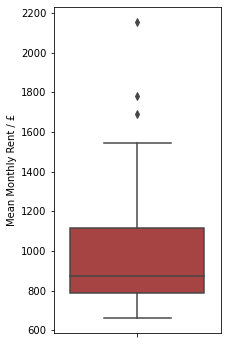

In [15]:
# Create a subset of data
df_rent = ldn_venue_data[['Postcode','Mean Monthly Rent / £']]

# Plot a box plot
plt.figure(figsize=(3,6))
sns.boxplot(y='Mean Monthly Rent / £', data = df_rent, color = '#B63434')

plt.show()

In [16]:
df_rent.describe().round(2)

,Mean Monthly Rent / £
count,160.00
mean,971.12
std,265.35
min,659.00
25%,785.00
50%,874.50
75%,1115.50
max,2154.00


**b. Identify the most common venue types in each district**

In [17]:
# Write a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [18]:
# Create a dataframe and display the top 5 venue categories for each neighbourhood

# Initialise parameters
num_top_venues = 5
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
columns = ['Postcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
ldn_venue_data_2 = pd.DataFrame(columns=columns)
ldn_venue_data_2['Postcode'] = ldn_venues_v3['Postcode_temp']

for ind in np.arange(ldn_venue_data.shape[0]):
    ldn_venue_data_2.iloc[ind, 1:] = return_most_common_venues(ldn_venues_v3.iloc[ind, :], num_top_venues)

ldn_venue_data_2

,Postcode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,BR1,Pub,Clothing Store,Coffee Shop,Indian Restaurant,Café
1,BR3,Italian Restaurant,Park,Coffee Shop,Café,Indian Restaurant
2,BR4,Supermarket,Pizza Place,Pharmacy,Coffee Shop,Hardware Store
3,BR6,Platform,Coffee Shop,Pub,Train Station,Pizza Place
4,CR0,Park,Pub,Grocery Store,Café,Bakery
...,...,...,...,...,...,...
155,W8,Café,Italian Restaurant,Pub,Restaurant,Hotel
156,W9,Pub,Café,Pizza Place,Fish & Chips Shop,Persian Restaurant
157,WC1E,Coffee Shop,Pizza Place,Bookstore,Hotel,Tapas Restaurant
158,WC1H,Coffee Shop,Hotel,Italian Restaurant,Café,Pub


It looks like Coffee Shops, Cafes, Pubs, Bars and Italian Restaurants are commonly occuring. We can plot mean monthly rent, against the frequency these venues appear in our districts to see if alone they might have any bearing on our target variable.

**c. Create scatter plots to inspect potential correlations between venue density and rent** \
We'll briefly explore three visualisations: \
    i. Average rent vs common venues \
    ii. Average rent vs more up-market venues \
    iii. Average rent vs total number of venues

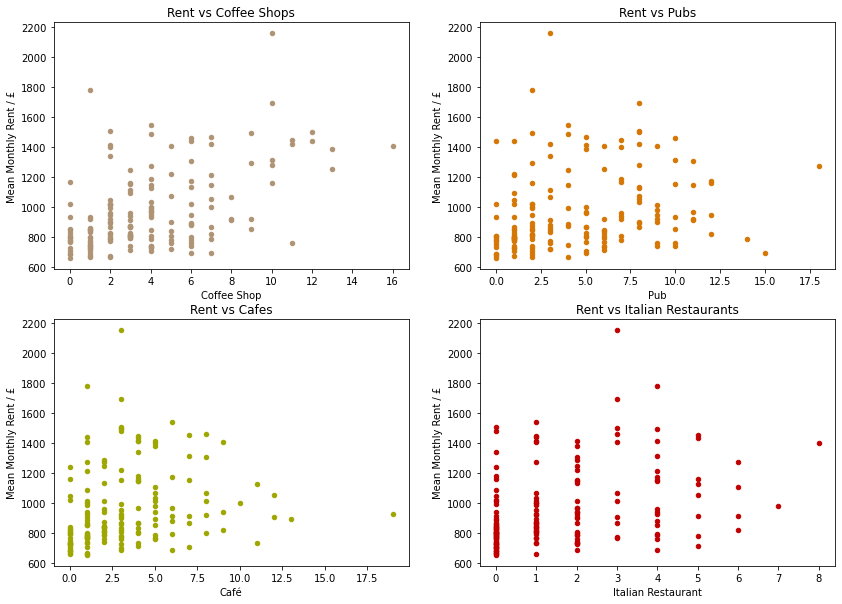

In [19]:
# Create a figure
fig = plt.figure() 

# Add subplots using the artist layer of matplotlib
ax0 = fig.add_subplot(2, 2, 1) # Add subplot 1 (2 rows, 2 columns, first plot)
ax1 = fig.add_subplot(2, 2, 2) # Add subplot 2
ax2 = fig.add_subplot(2, 2, 3) # Add subplot 3
ax3 = fig.add_subplot(2, 2, 4) # Add subplot 4

# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Coffee Shop', y = 'Mean Monthly Rent / £', color='#AF9375', figsize = (14,10), ax=ax0)
ax0.set_title('Rent vs Coffee Shops')

# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Pub', y = 'Mean Monthly Rent / £', color='#D57705', figsize = (14,10), ax=ax1)
ax1.set_title('Rent vs Pubs')

# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Café', y = 'Mean Monthly Rent / £', color='#9EA602', figsize = (14,10), ax=ax2)
ax2.set_title('Rent vs Cafes')

# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Italian Restaurant', y = 'Mean Monthly Rent / £', color='#C00000', figsize = (14,10), ax=ax3)
ax3.set_title('Rent vs Italian Restaurants')

plt.show()

In [20]:
pearson_coef1, p_value1 = stats.pearsonr(ldn_venue_data['Coffee Shop'], ldn_venue_data['Mean Monthly Rent / £'])
pearson_coef2, p_value2 = stats.pearsonr(ldn_venue_data['Pub'], ldn_venue_data['Mean Monthly Rent / £'])
pearson_coef3, p_value3 = stats.pearsonr(ldn_venue_data['Café'], ldn_venue_data['Mean Monthly Rent / £'])
pearson_coef4, p_value4 = stats.pearsonr(ldn_venue_data['Italian Restaurant'], ldn_venue_data['Mean Monthly Rent / £'])

correlations = {'Venue Type': ['Coffee Shop','Pub','Café','Italian Restaurant'],
                'Pearson Correlation':[pearson_coef1, pearson_coef2,pearson_coef3,pearson_coef4],
                'P value':[p_value1,p_value2,p_value3,p_value4]}
df = pd.DataFrame(data=correlations)
df

,Venue Type,Pearson Correlation,P value
0,Coffee Shop,0.504991,9.787411e-12
1,Pub,0.210453,7.559199e-03
2,Café,0.198925,1.167739e-02
3,Italian Restaurant,0.336128,1.389582e-05


These are pretty weak positive correlations, so alone will not allow us to predict average rent without a lot of uncertainty. 
\
\
Maybe more indicative venue types might be those which traditionally serve a customer of a certain wealth. Let's try wine bars and gyms.

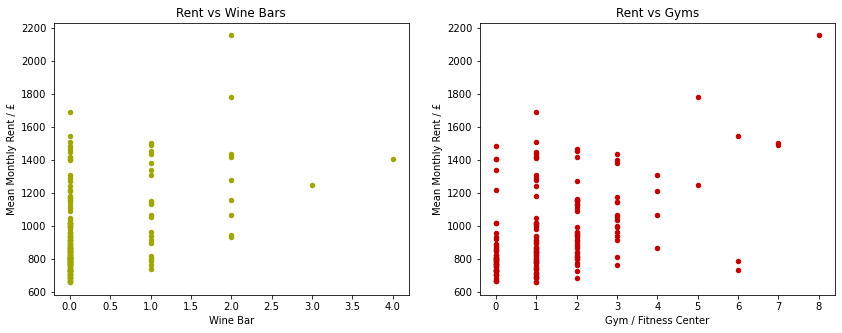

In [21]:
# Create a figure
fig = plt.figure() 

# Add subplots using the artist layer of matplotlib
ax0 = fig.add_subplot(1, 2, 1) # Add subplot 1 (2 rows, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # Add subplot 2


# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Wine Bar', y = 'Mean Monthly Rent / £', color='#9EA602', figsize = (14,5), ax=ax0)
ax0.set_title('Rent vs Wine Bars')

# Subplot 2
ldn_venue_data.plot(kind='scatter', x = 'Gym / Fitness Center', y = 'Mean Monthly Rent / £', color='#C00000', figsize = (14,5), ax=ax1)
ax1.set_title('Rent vs Gyms')


plt.show()

In [22]:
pearson_coef5, p_value5 = stats.pearsonr(ldn_venue_data['Wine Bar'], ldn_venue_data['Mean Monthly Rent / £'])
pearson_coef6, p_value6 = stats.pearsonr(ldn_venue_data['Gym / Fitness Center'], ldn_venue_data['Mean Monthly Rent / £'])

correlations = {'Venue Type': ['Wine Bar', 'Gym / Fitness Center'],
                'Pearson Correlation':[pearson_coef5, pearson_coef6],
                'P value':[p_value5,p_value6]}
df = pd.DataFrame(data=correlations)
df

,Venue Type,Pearson Correlation,P value
0,Wine Bar,0.437773,7.086938e-09
1,Gym / Fitness Center,0.476521,1.896839e-10


The correlation coefficients are a little higher, but still quite weak.
\
\
Let's see if total number of venues within a 1km radius has any correlation to rent.

In [23]:
# Sum the number of venues per district into a new column
ldn_venue_totals = ldn_venue_data.copy()
ldn_venue_totals['Total Venues'] = ldn_venue_totals.iloc[:,7:389].sum(axis = 1)

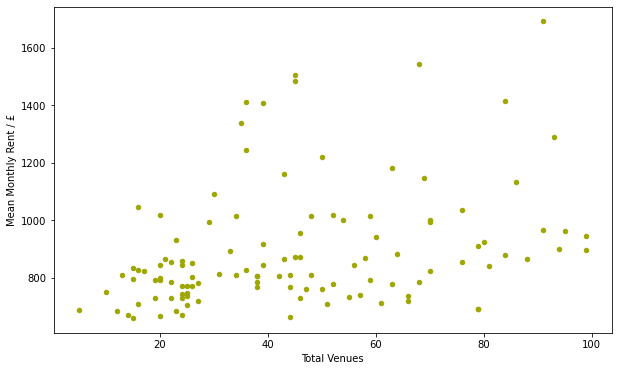

In [24]:
# For some reason the cap on the number of venues called from one area seems to be 100 (even though the limit is set at 200)
# Remove the districts with 100+ surrounding venues
ldn_venue_totals['Total Venues'].replace(100,np.nan,inplace=True)
ldn_venue_totals.dropna(inplace=True)

# Plot a scatter graph
ldn_venue_totals.plot(kind='scatter', x = 'Total Venues', y = 'Mean Monthly Rent / £', color='#9EA602', figsize = (10,6))
plt.show()

In [25]:
pearson_coef7, p_value7 = stats.pearsonr(ldn_venue_totals['Total Venues'], ldn_venue_totals['Mean Monthly Rent / £'])

correlations = {'Predictive variable': ['Total Venues'],
                'Pearson Correlation':[pearson_coef7],
                'P value':[p_value7]}
df = pd.DataFrame(data=correlations)
df

,Predictive variable,Pearson Correlation,P value
0,Total Venues,0.334941,0.000253


This is a weak correlation. Perhaps with more venues and observables at our disposal the coefficient might increase, but looking at the scatter plot it's clear that any positive correlation is dilute. We won't use this variable in our modelling.

**d. Plot distance against rent and engineer to linear relationship**

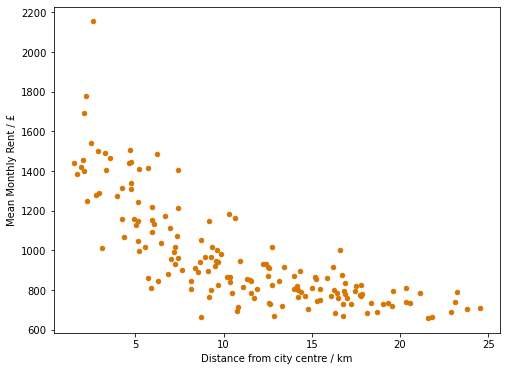

In [26]:
# Plot a scatter diagram
ldn_venue_data.plot(kind ='scatter', 
                    x = 'Distance from city centre / km', 
                    y = 'Mean Monthly Rent / £',
                   color = '#D57705',
                   figsize = (8,6))

Looks like mean rent has an inverse relationship to distance from city centre. We can see if using the reciprocal gives us a straight line regression plot.

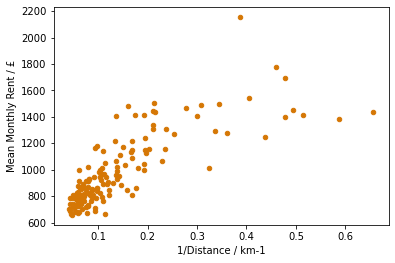

In [27]:
# Create a new dataframe to work with reciprocal
df_inverse_dist = ldn_venue_data[['Distance from city centre / km', 'Mean Monthly Rent / £']].copy()
df_inverse_dist['1/Distance / km-1'] = (np.reciprocal(df_inverse_dist['Distance from city centre / km']))

# Plot a scatter diagram
df_inverse_dist.plot(kind ='scatter', 
                    x = '1/Distance / km-1', 
                    y = 'Mean Monthly Rent / £',
                   color = '#D57705',
                   figsize = (6,4))

plt.show()

This now looks like a square root relationship. We'll see if modifying the distance by a negative sqaure root (power of -0.5) gives us a straight line.

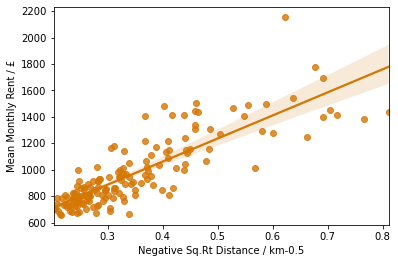

In [28]:
# Create a new dataframe to work with reciprocal
df_negsqrt_dist = ldn_venue_data[['Distance from city centre / km', 'Mean Monthly Rent / £']].copy()
df_negsqrt_dist['Negative Sq.Rt Distance / km-0.5'] = (np.reciprocal(df_inverse_dist['Distance from city centre / km']**0.5))

# Plot a scatter diagram
sns.regplot(x = 'Negative Sq.Rt Distance / km-0.5', 
            y = 'Mean Monthly Rent / £', 
            data = df_negsqrt_dist, 
            color='#D57705')

In [29]:
pearson_coef8, p_value8 = stats.pearsonr(df_negsqrt_dist['Negative Sq.Rt Distance / km-0.5'], df_negsqrt_dist['Mean Monthly Rent / £'])

correlations = {'Predictive variable': ['Neg Sq. Rt Distance'],
                'Pearson Correlation':[pearson_coef8],
                'P value':[p_value8]}
df = pd.DataFrame(data=correlations)
df

,Predictive variable,Pearson Correlation,P value
0,Neg Sq. Rt Distance,0.841369,4.493186e-44


**e. Finalise dataframe for model development** \
Now we've engineered the distance parameter suitable for linear regression, we can add the negative square root distance to the `ldn_venue_data` and clean it up for regression.

In [30]:
ldn_venue_data['Negative Sq.Rt Distance / km-0.5'] = df_negsqrt_dist['Negative Sq.Rt Distance / km-0.5'] 
ldn_venue_data.drop(['Area', 'Distance from city centre / km'], axis = 1, inplace = True)
ldn_venue_data.drop(['index'], axis = 1, inplace = True)
ldn_venue_data

,Postcode,Latitude,Longitude,Mean Monthly Rent / £,Accessories Store,Acupuncturist,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,...,Windmill,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Negative Sq.Rt Distance / km-0.5
0,BR1,51.4107,0.019429,706.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.259892
1,BR3,51.4034,-0.031774,719.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.273928
2,BR4,51.3756,-0.009892,671.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.244233
3,BR6,51.3674,0.092537,665.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.214220
4,CR0,51.3732,-0.078287,745.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.255666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,W13,51.5131,-0.321423,916.0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0.272940
156,W14,51.4954,-0.211163,1153.0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0.410653
157,WC1E,51.5207,-0.132398,1439.0,0,0,0,0,1,0,...,0,2,0,0,0,0,0,0,0,0.810247
158,WC1H,51.5248,-0.126315,1418.0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,0.716969


## 5. Train a mutliple linear regression algorithm with a subset of the data

**a. Select features**

In [31]:
# Define the features
X = ldn_venue_data.iloc[:, 4:386]

# Define the target variable
y = ldn_venue_data['Mean Monthly Rent / £'].values

**b. Split the data set into Training, Cross Validation and Test sets (60:20:20)**

In [32]:
# First, separate off 20% for testing
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = 29)

# Second, split the temporary data into training and CV sets
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 29)

# Check sizes
print ('Train set:', X_train.shape,  y_train.shape)
print ('CV set:', X_cv.shape,  y_cv.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (96, 382) (96,)
CV set: (32, 382) (32,)
Test set: (32, 382) (32,)


**c. Visualise the 3 sets on Folium** \
Before, we need to idtenify which set each postcode belongs to.

In [33]:
# Append a series of 1s to a new column in each feature set
X_train.insert(0, 'Train', 1)
X_cv.insert(0, 'CV', 1)
X_test.insert(0, 'Test', 1)

In [34]:
# Concatenate
set_split = pd.concat([ X_train, X_cv, X_test],axis = 1)
set_split_v2 = set_split[['Train', 'CV', 'Test']]

# Reverse get_dummies approach
set_split_v3 = pd.get_dummies(set_split_v2).idxmax(1)
set_split_v3.head()

0    Train
1       CV
2     Test
3    Train
4    Train
dtype: object

In [35]:
# Create a dataframe with the set that each postcode belongs to
coords = ldn_venue_data[['Postcode','Latitude','Longitude']]
postcode_sets = pd.concat([coords, set_split_v3],axis = 1)
postcode_sets.rename(columns = {0:'Set'}, inplace = True)
postcode_sets.head()

,Postcode,Latitude,Longitude,Set
0,BR1,51.4107,0.019429,Train
1,BR3,51.4034,-0.031774,CV
2,BR4,51.3756,-0.009892,Test
3,BR6,51.3674,0.092537,Train
4,CR0,51.3732,-0.078287,Train


In [36]:
# Plot a folium map

# Create map
postcode_set_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Select some marker colours for each set and create a new dataframe column
postcode_set_colours = postcode_sets.replace({'Train':'#B63434','CV':'#D57705','Test':'#9EA602'})

# Add markers to map
for lat, lng, postcode, sets, colour in zip(postcode_sets['Latitude'], postcode_sets['Longitude'], postcode_sets['Postcode'], postcode_sets['Set'], postcode_set_colours['Set']):
    label = '{}, {} set'.format(postcode, sets)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colour,
        fill=True,
        fill_color=colour,
        fill_opacity=0.7,
        parse_html=False).add_to(postcode_set_map)  
    
postcode_set_map

**d. Obtain a ridge regression model using Training and CV sets** \
We want to find a reasonable value for our regluarisation value alpha, which is what we employ our Cross Validation set to obtain.

In [37]:
# Normalise training set
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_cv = preprocessing.StandardScaler().fit(X_cv).transform(X_cv)

In [38]:
# Train the model and validate for different alphas in Ridge model with CV set

# Initialise mean and standard deviation arrays
Cs = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000, 3000, 10000]
mean_acc = np.zeros(13)
std_acc = np.zeros(13)


for i in Cs:
    
    # Train model with train set and predict with CV set, outputting MSE
    MLR = Ridge(alpha=i).fit(X_train,y_train)
    yhat=MLR.predict(X_cv)
    mean_acc[Cs.index(i)] = metrics.mean_squared_error(y_cv, yhat)
    std_acc[Cs.index(i)] = np.std((yhat-y_cv)**2)/np.sqrt(yhat.shape[0])

mean_acc_min_index = np.argmin(mean_acc)
print('Alpha value with the lowest MSE =',Cs[mean_acc_min_index])
print('Lowest MSE value = ',np.min(mean_acc).round(0))

Alpha value with the lowest MSE = 300
Lowest MSE value =  47202.0


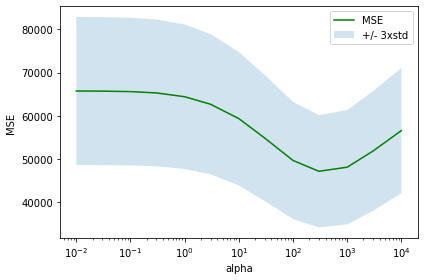

In [39]:
# Plot line graph of MSE against alpha
plt.plot(Cs,mean_acc,'g')
plt.fill_between(Cs,mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.20)
plt.xscale("log")
plt.legend(('MSE ', '+/- 3xstd'))
plt.ylabel('MSE ')
plt.xlabel('alpha')
plt.tight_layout()
plt.show()

In [40]:
# Train MLR model with alpha = 100
MLR_model = Ridge(alpha=100).fit(X_train,y_train)

## 6. Assess the regression model

**a. Run the model on the test data and view the predicted rent against actual rent**

In [41]:
# Run the model on normalised test data
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
y_MLR_test = MLR_model.predict(X_test)

In [42]:
# Write the results into a dataframe
results = pd.DataFrame({'Actual rent / £':y_test, 'Predicted rent / £':y_MLR_test, 'Absolute difference / £':abs(y_test-y_MLR_test)})
results.round(0)

,Actual rent / £,Predicted rent / £,Absolute difference / £
0,872.0,842.0,30.0
1,877.0,799.0,78.0
2,1175.0,1247.0,72.0
3,772.0,809.0,37.0
4,1013.0,988.0,25.0
5,1384.0,1197.0,187.0
6,671.0,864.0,193.0
7,1438.0,1279.0,159.0
8,1464.0,1053.0,411.0
9,712.0,925.0,213.0


In [43]:
# Check the MSE
print('Test MSE =',metrics.mean_squared_error(y_test, y_MLR_test).round(1))

Test MSE = 42354.8


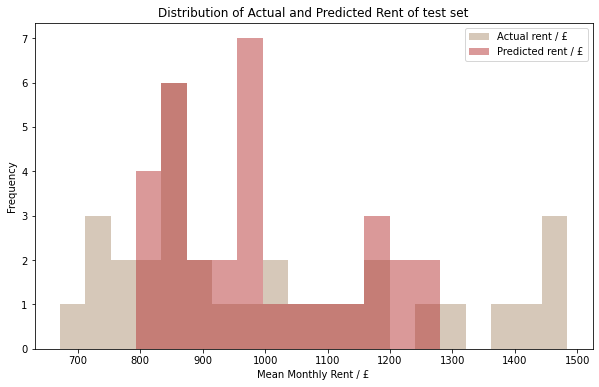

In [44]:
# Plot a histogram
results[['Actual rent / £','Predicted rent / £']].plot(kind ='hist', 
                                                  figsize=(10, 6),
                                                  bins=20,
                                                  alpha=0.5,
                                                  color=['#AF9375', '#B63434']
                                                 )

plt.title('Distribution of Actual and Predicted Rent of test set')
plt.xlabel('Mean Monthly Rent / £')
plt.show()

Clearly the predicted values occupy a narrower range than the actual target values in this case. This is one aspect we'll see if we can address later. Another concern is the difference between the MSE of our CV and test sets. Since the data set of postcodes isn't huge, it may be that our selection of CV and test sets affects a large variability in our error. \
\
We can repeat the modelling/testing/evaluating process for different randomisations.

**b. Test for different variations and take an average of MSE**

In [45]:
# Run MLR for 28 other randomisations of data
Max = 28
MSE = np.zeros((Max-1))
alpha_min_array = np.zeros((Max-1))

for n in range(1,Max):
    
    # Split data
    X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size = 0.20, random_state = n)
    X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = n)

    # Normalise sets
    X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
    X_cv = preprocessing.StandardScaler().fit(X_cv).transform(X_cv)
    X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    
    # Obtain the optimum value of alpha
    alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000]
    mean_acc = np.zeros(13)
    
    for i in alphas:
    
        # Train model with train set and predict with CV set, outputting MSE
        MLR = Ridge(alpha=i).fit(X_train,y_train)
        yhat=MLR.predict(X_cv)
        mean_acc[alphas.index(i)] = metrics.mean_squared_error(y_cv, yhat)

        # Select the alpha which gives the min MSE to take forward
        mean_acc_min_index = np.argmin(mean_acc)
        alpha_min = alphas[mean_acc_min_index]

    alpha_min_array[n-1] = alpha_min
        
    # Train model with train set
    MLR_model = Ridge(alpha = alpha_min_array[n-1]).fit(X_train,y_train)

    # Test model with test set
    y_MLR = MLR_model.predict(X_test)

    # Write MSE into array
    MSE[n-1] = metrics.mean_squared_error(y_test, y_MLR)
        
MSE

array([57448.54746976, 57441.22264052, 54116.71618245, 42119.86490534,
       69348.40333114, 53208.69442582, 63919.46359729, 54820.70550303,
       65058.84811535, 38888.37208389, 42722.10665125, 63043.56460863,
       20073.5832157 , 38214.59398151, 47537.69160732, 38619.31572515,
       63214.10625533, 60101.80416757, 51382.22390709, 31214.4900406 ,
       48631.62448457, 29802.87715458, 56544.61692332, 66108.88454668,
       23456.19888096, 40244.82955702, 55157.33861163])

In [46]:
# What is the average error over the 28 runs of MLR?
mean_MSE = np.mean(MSE).round(1)
print('Mean test error using all venue data and distance =', mean_MSE)

Mean test error using all venue data and distance = 49349.7


So there's a broad range of MSE values for our test data depending on the randomisation. \
\
It's worth checking to see if the venue frequency is actually helping or hindering our learning algorithm. We can check to see how it does with a simple linear regression algorithm using just distance from city centre data.

**c. Sense check model features by applying simple linear regression with only distance data**

In [47]:
# Create simple linear regression feature set
X_SLR = ldn_venue_data[['Negative Sq.Rt Distance / km-0.5']]

In [48]:
Max = 28
MSE_SLR = np.zeros((Max-1))
alpha_min_array = np.zeros((Max-1))

for n in range(1,Max):
    
    # Split data
    X_temp, X_test_SLR, y_temp, y_test = train_test_split(X_SLR, y, test_size = 0.2, random_state = n)
    X_train_SLR, X_cv_SLR, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = n)

    # Normalise sets
    X_train_SLR = preprocessing.StandardScaler().fit(X_train_SLR).transform(X_train_SLR)
    X_cv_SLR = preprocessing.StandardScaler().fit(X_cv_SLR).transform(X_cv_SLR)
    X_test_SLR = preprocessing.StandardScaler().fit(X_test_SLR).transform(X_test_SLR)
    
    # Obtain the optimum value of alpha
    alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000]
    mean_acc = np.zeros(13)
    
    for i in alphas:
    
        # Train model with train set and predict with CV set, outputting MSE
        SLR = Ridge(alpha=i).fit(X_train_SLR,y_train)
        yhat_SLR=SLR.predict(X_cv_SLR)
        mean_acc[alphas.index(i)] = metrics.mean_squared_error(y_cv, yhat_SLR)

        # Select the alpha which gives the min MSE to take forward
        mean_acc_min_index = np.argmin(mean_acc)
        alpha_min = alphas[mean_acc_min_index]

    alpha_min_array[n-1] = alpha_min

    # Train model with train set
    SLR_model = Ridge(alpha = alpha_min_array[n-1]).fit(X_train_SLR,y_train)

    # Test model with test set
    y_SLR = SLR_model.predict(X_test_SLR)

    # Write MSE into array
    MSE_SLR[n-1] = metrics.mean_squared_error(y_test, y_SLR)
        
MSE_SLR

array([25920.59155307, 32878.27262178, 14533.1170744 , 19373.38993216,
       36904.25864579, 27519.51744403, 25455.72269237, 26026.02457891,
       39256.90233832, 31292.73291268, 23223.79599977, 18086.07369507,
       17780.16352911, 16465.64400226, 19644.76460262,  9495.0921115 ,
       32244.22524063, 24140.82258248, 31248.57355854, 18547.50571128,
       25391.21743604, 19332.43924941, 21500.04261423, 34740.2184426 ,
       16633.00886438, 22596.38131526, 33839.43875139])

In [49]:
# What is the average error over the 28 runs of SLR?
mean_MSE_SLR =  np.mean(MSE_SLR).round(1)
print('Mean test error using only distance data =',mean_MSE_SLR)

Mean test error using only distance data = 24595.2


The fact that the SLR mean error is significantly lower than our MLR mean error could imply that we are overfitting the data for the MLR model. This is more common when m is small but n is large. \
\
Perhaps we can improve by only including a few venue features in our feature set?

**d. Apply MLR with only a couple of venue features to check if there's any improvement on the SLR error**

In [50]:
# Create simple linear regression feature set
X_v2 = ldn_venue_data[['Wine Bar', 'Gym / Fitness Center','Negative Sq.Rt Distance / km-0.5']]

In [51]:
Max = 28
MSE_v2 = np.zeros((Max-1))
alpha_min_array = np.zeros((Max-1))

for n in range(1,Max):
    
    # Split data
    X_temp, X_test_v2, y_temp, y_test = train_test_split(X_v2, y, test_size = 0.20, random_state = n)
    X_train_v2, X_cv_v2, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = n)

    # Normalise sets
    X_train_v2 = preprocessing.StandardScaler().fit(X_train_v2).transform(X_train_v2)
    X_cv_v2 = preprocessing.StandardScaler().fit(X_cv_v2).transform(X_cv_v2)
    X_test_v2 = preprocessing.StandardScaler().fit(X_test_v2).transform(X_test_v2)
    
    # Obtain the optimum value of alpha
    alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000]
    mean_acc = np.zeros(13)
    
    for i in alphas:
    
        # Train model with train set and predict with CV set, outputting MSE
        MLR = Ridge(alpha=i).fit(X_train_v2,y_train)
        yhat=MLR.predict(X_cv_v2)
        mean_acc[alphas.index(i)] = metrics.mean_squared_error(y_cv, yhat)

        # Select the alpha which gives the min MSE to take forward
        mean_acc_min_index = np.argmin(mean_acc)
        alpha_min = alphas[mean_acc_min_index]
        
    alpha_min_array[n-1] = alpha_min

    # Train model with train set
    MLR_v2_model = Ridge(alpha = alpha_min_array[n-1]).fit(X_train_v2,y_train)

    # Test model with test set
    y_MLR_v2 = MLR_v2_model.predict(X_test_v2)

    # Write MSE into array
    MSE_v2[n-1] = metrics.mean_squared_error(y_test, y_MLR_v2)
        
MSE_v2

array([26646.74782654, 38007.26211654, 12497.89850278, 19687.4140198 ,
       38263.75019439, 26644.21726185, 37155.70315223, 22047.92110576,
       31186.13323473, 43771.13519895, 22798.98079983, 17912.28942741,
       16882.82384711, 20515.56859003, 17147.2573341 , 10481.06671182,
       35063.38317272, 32862.5026443 , 28540.83571603, 18371.58203123,
       27059.52886836, 16070.5127941 , 21803.4510644 , 31816.08985801,
       15958.97713037, 25109.68507214, 24582.80780714])

In [52]:
# What is the average error over the 28 runs of reduced MLR?
mean_MSE_v2 = np.mean(MSE_v2).round(1)
print('Mean test error using 3 features including distance =',mean_MSE_v2)

Mean test error using 3 features including distance = 25143.9


In [53]:
MSE = {'Number of venue features': ['384', '0', '2'],
                'MSE':[mean_MSE, mean_MSE_SLR, mean_MSE_v2],
                }
df = pd.DataFrame(data=MSE)
df

,Number of venue features,MSE
0,384,49349.7
1,0,24595.2
2,2,25143.9


Ok, so our venue data is obfuscating our algorithm slightly, even with a couple of features we might have expected to have roughly linear relationships with rent price. No useful additional information is being added by supplementing a simple linear model with venue data. Potential redundancy can be checked by comparing correlation coefficients

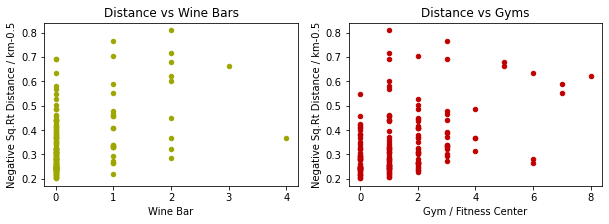

In [54]:
# Create a figure
fig = plt.figure() 

# Add subplots using the artist layer of matplotlib
ax0 = fig.add_subplot(1, 2, 1) # Add subplot 1 (2 rows, 2 columns, first plot)
ax1 = fig.add_subplot(1, 2, 2) # Add subplot 2


# Subplot 1
ldn_venue_data.plot(kind='scatter', x = 'Wine Bar', y = 'Negative Sq.Rt Distance / km-0.5', color='#9EA602', figsize = (10,3), ax=ax0)
ax0.set_title('Distance vs Wine Bars')

# Subplot 2
ldn_venue_data.plot(kind='scatter', x = 'Gym / Fitness Center', y = 'Negative Sq.Rt Distance / km-0.5', color='#C00000', figsize = (10,3), ax=ax1)
ax1.set_title('Distance vs Gyms')


plt.show()

In [55]:
pearson_coef9, p_value9 = stats.pearsonr(ldn_venue_data['Wine Bar'], ldn_venue_data['Negative Sq.Rt Distance / km-0.5'])
pearson_coef10, p_value10 = stats.pearsonr(ldn_venue_data['Gym / Fitness Center'], ldn_venue_data['Negative Sq.Rt Distance / km-0.5'])

correlations = {'Venue Type': ['Wine Bar', 'Gym / Fitness Center'],
                'Pearson Correlation (Distance)':[pearson_coef9, pearson_coef10],
                'Pearson Correlation (Rent)':[pearson_coef5, pearson_coef6]}
df = pd.DataFrame(data=correlations)
df

,Venue Type,Pearson Correlation (Distance),Pearson Correlation (Rent)
0,Wine Bar,0.433006,0.437773
1,Gym / Fitness Center,0.410149,0.476521


These two features are clearly quite redundant in this case. It may be that some aren't redundant, but where venue incidence has more or less the same correlation to distance as it does to the target variable, it is not valuable for training a learning algorithm. 

**e. Check the prediction distribution of SLR and adapt error weights if necessary to see if performs better**

Going back to our best performing SLR model, we can check how it's prediction compare to reality regarding distribution. We'll try it on a different random state (100)

In [56]:
# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X_SLR, y, test_size = 0.20, random_state = 100)
X_train, X_cv, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = 100)

# Normalise sets
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_cv = preprocessing.StandardScaler().fit(X_cv).transform(X_cv)
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
    
# Obtain the optimum value of alpha
alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000]
mean_acc = np.zeros(13)
    
for i in alphas:
    
        # Train model with train set and predict with CV set, outputting MSE
        MLR = Ridge(alpha=i).fit(X_train,y_train)
        yhat=MLR.predict(X_cv)
        mean_acc[alphas.index(i)] = metrics.mean_squared_error(y_cv, yhat)

        # Select the alpha which gives the min MSE to take forward
        mean_acc_min_index = np.argmin(mean_acc)
        alpha_min = alphas[mean_acc_min_index]
        
# Train model with train set
SLR_model_v2 = Ridge(alpha = alpha_min).fit(X_train,y_train)

# Test model with test set
y_SLR_v2 = SLR_model_v2.predict(X_test)

# Print mean MSE
mean_MSE = np.mean(mean_acc).round(1)
print('Mean test error using SLR including distance =',mean_MSE)

results_SLR = pd.DataFrame({'Actual rent / £':y_test, 'Predicted rent / £':y_SLR_v2, 'Absolute difference / £':abs(y_test-y_SLR_v2)})
results_SLR.head().round(0)

Mean test error using SLR including distance = 28314.9


,Actual rent / £,Predicted rent / £,Absolute difference / £
0,750.0,863.0,113.0
1,1340.0,1195.0,145.0
2,782.0,846.0,64.0
3,786.0,928.0,142.0
4,728.0,823.0,95.0


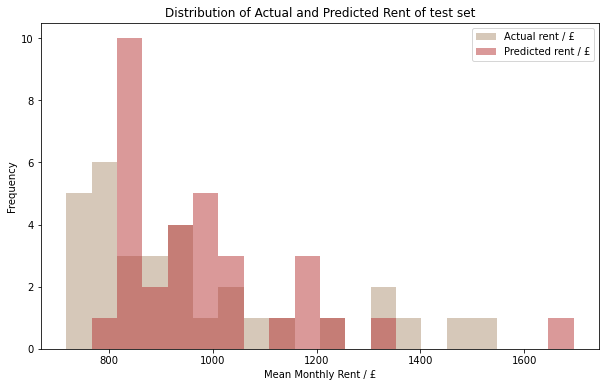

In [57]:
# Plot a histogram
results_SLR[['Actual rent / £','Predicted rent / £']].plot(kind ='hist', 
                                                  figsize=(10, 6),
                                                  bins=20,
                                                  alpha=0.5,
                                                  color=['#AF9375', '#B63434']
                                                 )

plt.title('Distribution of Actual and Predicted Rent of test set')
plt.xlabel('Mean Monthly Rent / £')
plt.show()

We can do better than this though. Let's tally the results over 28 iterations as before and then plot a histogram with clearer distributions.

In [58]:
Max = 28
alpha_min_array = np.zeros((Max-1))
columns = list(results_SLR)
data = []

for n in range(1,Max):
    
    # Split data
    X_temp, X_test_SLR, y_temp, y_test = train_test_split(X_SLR, y, test_size = 0.2, random_state = n)
    X_train_SLR, X_cv_SLR, y_train, y_cv = train_test_split(X_temp, y_temp, test_size = 0.25, random_state = n)

    # Normalise sets
    X_train_SLR = preprocessing.StandardScaler().fit(X_train_SLR).transform(X_train_SLR)
    X_cv_SLR = preprocessing.StandardScaler().fit(X_cv_SLR).transform(X_cv_SLR)
    X_test_SLR = preprocessing.StandardScaler().fit(X_test_SLR).transform(X_test_SLR)
    
    # Obtain the optimum value of alpha
    alphas = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30 , 100, 300, 1000]
    mean_acc = np.zeros(13)
    
    for i in alphas:
    
        # Train model with train set and predict with CV set, outputting MSE
        SLR = Ridge(alpha=i).fit(X_train_SLR,y_train)
        yhat_SLR=SLR.predict(X_cv_SLR)
        mean_acc[alphas.index(i)] = metrics.mean_squared_error(y_cv, yhat_SLR)

        # Select the alpha which gives the min MSE to take forward
        mean_acc_min_index = np.argmin(mean_acc)
        alpha_min = alphas[mean_acc_min_index]

    alpha_min_array[n-1] = alpha_min

    # Train model with train set
    SLR_model = Ridge(alpha = alpha_min_array[n-1]).fit(X_train_SLR,y_train)

    # Test model with test set
    y_SLR_n = SLR_model.predict(X_test_SLR)

    # Write lists 
    values = [y_test, y_SLR_n, abs(y_test-y_SLR_v2)]
    zipped = zip(columns, values)
    results_n = dict(zipped)
    data.append(results_n)
    
results_SLR = results_SLR.append(data, True)    
results_SLR_v2 = results_SLR.apply(pd.Series.explode).reset_index() # Explode lists within dataframes
results_SLR_v2.round(0)

,index,Actual rent / £,Predicted rent / £,Absolute difference / £
0,0,750,863.023,113.023
1,1,1340,1195.15,144.855
2,2,782,845.719,63.7194
3,3,786,928.388,142.388
4,4,728,822.565,94.5645
...,...,...,...,...
891,58,867,866.062,109.734
892,58,1277,1297.49,429.106
893,58,1182,935.511,58.3971
894,58,922,950.91,118.548


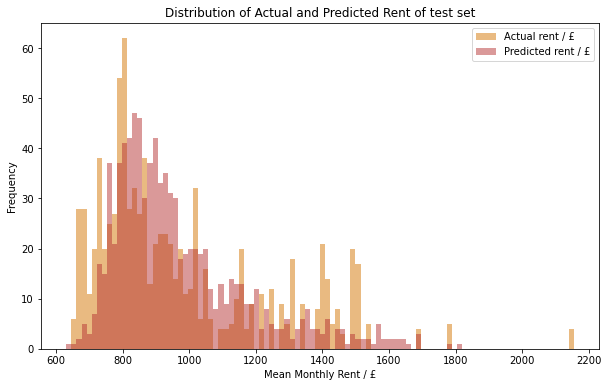

In [59]:
results_SLR_v2[['Actual rent / £','Predicted rent / £']].plot(kind ='hist', 
                                                  figsize=(10, 6),
                                                  bins=100,
                                                  alpha=0.5,
                                                  color=['#D57705', '#B63434']
                                                 )

plt.title('Distribution of Actual and Predicted Rent of test set')
plt.xlabel('Mean Monthly Rent / £')
plt.show()